In [1]:
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import numpy as np
from astropy import units as u
from astropy.nddata import CCDData
from astropy.stats import gaussian_sigma_to_fwhm
from ccdproc import Combiner
from photutils.detection import DAOStarFinder

In [2]:
def import_images(im_list, p):
    '''
    A function that imports the data from an image file, following a given
    path to find the image file
    
        Paramters
        ---------
        im_list: list
            List containing the names of the image files
        p: string
            The pathway the script should follow to find the image
            files on the computer

        Returns
        -------
        im_data: list
            A list of the data arrays containing the pixel data
            of images
    '''
    im_data = []
    for i in im_list:
        path = p + i
        hdu = fits.open(path)
        data = hdu[1].data
        im_data.append(data)
    
    return im_data


def find_stars(image, sigma=5.0, peak=100000):
    '''
    Searches data from an image to find objects above a given brightness
    threshold based off parameters of the ccd chip
        
        Parameters
        ----------
        image: array-like
            Array containing the intensity of light for each pixel
            on the ccd chip
        sigma: float
            sets the size tolerance for detected objects. Usually
            5.0, more than 5 is statistically unreasonable
        peak: int
            The max number of counts the chip can handle before the 
            image starts to smear. Usual ccd can handle 100,000 counts
            
        Returns
        -------
        stars: table
            A table containing all the found stars and their parameters:
            id, xcentroid, ycentroid, sharpness, roundness, npix, sky,
            peak, flux, mag
    '''
    sigma_psf = sigma
    bkg = np.std(image)
    daofind = DAOStarFinder(fwhm=sigma_psf*gaussian_sigma_to_fwhm, threshold=3.*bkg, peakmax=peak)
    stars = daofind(image)
    
    return stars


def calculate_shift(stars1, stars2):
    '''
    Calculates the necessary shift of one image in order to be aligned 
    with a second image
    
        Parameters
        ----------
        stars1: table
            The table returned from using find_stars on an image
        stars2: table
            Same as stars1, for a different image
        
        Returns
        -------
        diff: table
            Table containing the x, y, and total offset of each star object
            found between two images
    '''
    diff = np.zeros([stars1['xcentroid'].size, 3])*np.nan
    for i in range(stars1['xcentroid'].size):
        dx = stars1['xcentroid'][i] - stars2['xcentroid']
        dy = stars1['ycentroid'][i] - stars2['ycentroid']
        distances = np.abs(np.sqrt((dx)**2 + (dy)**2))
        match = (distances == np.min(distances))
        if distances[match] < 20:
            diff[i, 0] = distances[match]
            diff[i, 1] = dx[match]
            diff[i, 2] = dy[match]
               
    return diff


def roll_image(image, diff, threshold=0.5):
    '''
    Averages the x and y offset of objects on 2 images to the nearest 
    integer, and then rolls the image by that number of pixels along each
    axis. Good for aligning two images
        
        Parameters
        ----------
        image: array-like
            Array containing the intensity of light for each pixel
            on the ccd chip
        diff: table
            Table containing the x, y, and total offset of each star object
            found between two images
        threshold: float
            The minimum pixel offset between images to allow shifting,
            usually 0.5 pixels
            
        Returns
        -------
        image_shift: array-like
            The "rolled" version of the same image, now aligned to another
            reference image
    '''
    offset = np.median(diff[:, 0])
    if offset >= threshold:
        xshift = np.median(diff[:, 1])
        yshift = np.median(diff[:, 2])
        xshift_int = np.int(np.round(xshift, 0))
        yshift_int = np.int(np.round(yshift, 0))
        image_shift = np.roll(image, (yshift_int, xshift_int), axis = (0, 1))
    
        return image_shift
    else:
        return image
    

def median_combiner(images):
    '''
    Function that takes the median of multiple images containing the
    same stars objects
        
        Parameters
        ----------
        images: list
            A list of the data arrays containing the pixel data
            of images
        
        Returns
        -------
        median_image: array-like
            Array containing the median intensity of light for each 
            pixel for a set of images
    '''
    ccd_image_list = []
    
    for image in images:
        ccd_image = CCDData(image, unit=u.adu)
        ccd_image_list.append(ccd_image)
        
    c = Combiner(ccd_image_list)
    c.sigma_clipping(func = np.ma.median)
    median_image = c.median_combine()
    median_image = np.asarray(median_image)
    
    return median_image

In [3]:
def image_combiner(im_list, p):
    im_data = import_images(im_list=im_list, p=p)
    stars = []
    for i in im_data:
        s = find_stars(image=i, sigma=5.0, peak=100000)
        stars.append(s)
    diffs = []
    for s in range(len(stars)):
            diff = calculate_shift(stars1=stars[0], stars2=stars[s])
            diffs.append(diff)
    images = []
    for i in range(len(im_data)):
        image_shift = roll_image(image=im_data[i], diff=diffs[i], threshold=0.5)
        images.append(image_shift)
    median_image = median_combiner(images=images)
    
    return median_image

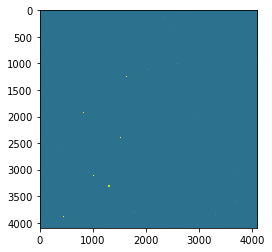

In [4]:
def main():
    images = ['image61.fz', 'image62.fz', 'image63.fz']
    path = 'C:\\Users\\Horatio the Bold\\Documents\\Python\\epochs\\61, 62, 63\\'
    median_image = image_combiner(im_list=images, p=path)
    median = np.median(median_image)
    std = np.std(median_image)
    plt.imshow(median_image, interpolation='none', vmin=median-3*std, vmax=median+5*std)
main()